# Set Up

In [1]:
#command line items
%load_ext autoreload
%autoreload 2

#python imports
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage.filters import gaussian_filter
from astropy.cosmology import FlatLambdaCDM
from copy import copy
from numpy import nan


from pylab import *
import astropy.io.fits as fits
from scipy.io import readsav
from matplotlib.colors import LogNorm
from astropy.visualization import (ZScaleInterval, ImageNormalize)
import matplotlib.patches as patches
#from plot_grids import *
import scipy.integrate as integrate

Red = '\033[91m'
Green = '\033[92m'
Blue = '\033[94m'
Cyan = '\033[96m'
Yellow = '\033[93m'
Magenta = '\033[95m'
CEND = '\033[0m'

/tmp/ipykernel_23434/989343433.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


# Calculate Scales

In [2]:
# [OII] and MgII wavelenght
o2 = [3726.03, 3728.82]
mg2 = [2795.5301, 2802.7056]

#Redshift of the source
z = 0.043118

#check that the python library gives the same result as the  manual calculation
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.315, Tcmb0=2.725)
arcsec_kpc = cosmo.arcsec_per_kpc_proper(z) 
deg_kpc = arcsec_kpc / 60. /60. # degree size of 1 kpc

print(Green + 'Check using FlatLambdaCDM, scale:' + CEND, arcsec_kpc, 1/arcsec_kpc)

#Set some constants
h0 = 67.4
Om = 0.315
Ol = 1 - Om
c_light = 299792.458

#Estimate the Angular Diameter Distance 
def func(x):
    return 1/np.sqrt( Om * (1+x)**3 + Ol)

result = integrate.quad(lambda x: func(x), 0, z)
da = c_light/h0*1/(1+z)* (result[0])
print(Red + 'Angular Diameter Distance is' + CEND, da, Red + 'Mpc' + CEND)

# 4.84814e-6 is rad in arcsec, 1000 is to have the scale in kpc
x = da * 1000 * 4.84814e-6

# 8.096e-5 is the pixel scale along slice, 3600 is to convert it in arcsec (0.291456)
pixel_size = 8.096e-5 * 3600
pixel_scale = x * pixel_size


arcsec_pixel =  pixel_scale / x

print (Blue + "Scale: 1 arcsec is" + CEND, x, Blue + "kpc" + CEND)
print (Magenta + "Scale: 1 pixel is" + CEND, pixel_scale, Magenta + "kpc" + CEND)
print (Cyan + "FOV for z" + CEND, z, Cyan + "is" + CEND, 16.5 * x, 'x', 20.4 * x, Cyan + "kpc" + CEND,)
print (Yellow + "Scale: 1 pixel is" + CEND, arcsec_pixel, Yellow + "arcsec" + CEND)


Check using FlatLambdaCDM, scale: 1.1335033945669866 arcsec / kpc 0.8822205604262997 kpc / arcsec
Angular Diameter Distance is 181.9717830858933 Mpc
Scale: 1 arcsec is 0.8822246804500427 kpc
Scale: 1 pixel is 0.25712967646524765 kpc
FOV for z 0.043118 is 14.556707227425704 x 17.99738348118087 kpc
Scale: 1 pixel is 0.291456 arcsec


# Read Files 1 component fit

In [3]:
data_1comp = readsav('/home/acoil/AGN_outflows_ifsfit/F05189/iter3/F05189.xdr')
data_arr_1comp = data_1comp['windstr']

lin_data_1comp = readsav('/home/acoil/AGN_outflows_ifsfit/F05189/iter3/F05189.lin.xdr')
print(lin_data_1comp.keys())

dict_keys(['emlwav', 'emlwaverr', 'emlsig', 'emlsigerr', 'emlweq', 'emlflx', 'emlflxerr', 'emlcvdf', 'emlpcor'])


# Load Arrays 1 component fit

In [4]:
data_flx_1comp = lin_data_1comp['emlflx'][0][8]
data_flx_err_1comp = lin_data_1comp['emlflxerr'][0][8]
vel_arr_1comp = data_arr_1comp['E_VEL'][0][0][8]

print('###### FLUX AND ERR #########') 
for i in range(len(data_flx_1comp)):
    if data_flx_1comp[i][0] != None:
        print(i,data_flx_1comp[i][0])
            
print('####### VEL ########')        
for i in range(len(vel_arr_1comp)):
    if vel_arr_1comp[i][0] != None:
        print(i,vel_arr_1comp[i][0])        

###### FLUX AND ERR #########
0 b'ftot'
5 b'fc1'
6 b'fc1pk'
####### VEL ########
0 b'v%84c1'
4 b'v%02c1'
5 b'v%50c1'
8 b'vsigc1'
9 b'v%98'
11 b'v%16'
14 b'vpk'
15 b'v%50'
16 b'vsig'
17 b'v%02'
19 b'vsigc1err'
24 b'v%50c1err'
27 b'v%84'
28 b'v%98c1'
31 b'v%16c1'


# Read Files 2 components fit

In [6]:
data = readsav('/raid/KCWI/AGN_outflows/F05189/iter2/F05189.xdr')
data_arr = data['windstr']
#print(data_arr.dtype.names)

lin_data = readsav('/raid/KCWI/AGN_outflows/F05189/iter2/F05189.lin.xdr')
print(lin_data.keys())

dict_keys(['emlwav', 'emlwaverr', 'emlsig', 'emlsigerr', 'emlweq', 'emlflx', 'emlflxerr', 'emlcvdf', 'emlpcor'])


# Load Arrays 2 components fit

In [7]:
data_flx = lin_data['emlflx'][0][8]
data_flx_err = lin_data['emlflxerr'][0][8]
vel_arr = data_arr['E_VEL'][0][0][8]

print('###### FLUX AND ERR #########') 
for i in range(len(data_flx)):
    if data_flx[i][0] != None:
        print(i,data_flx[i][0])
            
print('####### VEL ########')        
for i in range(len(vel_arr)):
    if vel_arr[i][0] != None:
        print(i,vel_arr[i][0])        

###### FLUX AND ERR #########
0 b'ftot'
1 b'fc2'
4 b'fc2pk'
5 b'fc1'
6 b'fc1pk'
####### VEL ########
0 b'v%84c1'
4 b'v%02c1'
5 b'v%50c1'
8 b'v%98c2'
9 b'v%98'
10 b'vsigc1'
11 b'v%16'
12 b'vsigc2'
13 b'v%84c2'
14 b'vpk'
15 b'v%50'
16 b'vsig'
17 b'v%02'
18 b'v%50c2'
19 b'v%50c2err'
20 b'vsigc2err'
21 b'v%02c2'
22 b'vsigc1err'
24 b'v%16c2'
25 b'v%50c1err'
27 b'v%84'
28 b'v%98c1'
31 b'v%16c1'


# Total Flux 2 components fit

In [8]:
ftot = data_flx[0][1][0][8]
err_ftot = data_flx_err[0][1][0][8]

print('####### LINES ########') 
for i in range(len(ftot)):
    if ftot[i][0] != None:
        print(i,ftot[i][0])

####### LINES ########
0 b'Hbeta'
4 b'[OII]3726'
5 b'[OII]3726+[OII]3729'
9 b'[NeIII]3869'
12 b'[OII]3729'
13 b'[OIII]5007'
14 b'[OIII]4959'
15 b'Hgamma'


# Functions to get data for maps

In [9]:
err_thresh = 0.0022 #set the error threshold after exploring the error arrays

def set_sn(arr, arr2):
    sn_cut = np.where(arr < 4) #change here the SN threshold, now set to 3
    arr2[sn_cut] = nan   #if the SN is less than 3, remove that spaxel
    return arr2

def set_bad(arr):
    bad = (arr > 1e90)   
    arr[bad] = nan   
   # bad2 = (arr < 1e-26)
   # arr[bad2] = nan
    return arr   

def get_flux_uncorr(idx, arr, arr2):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    
    f = set_bad(f)
    f_err = set_bad(f_err)  

    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
        
    sn = f/f_err
    f = set_sn(sn,f)  
    return f

def get_err_flux(idx, arr):
    f_err = copy(arr[idx][1])
    f_err = set_bad(f_err)  
    
    return f_err

    
def get_v50(idx, arr, arr2, arr3):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])

    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(arr3[idx][1])
    v = set_bad(v)
    v = set_sn(sn,v)
    return v 

def get_vsig(idx, arr, arr2, arr3):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    
    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(arr3[idx][1])
    v = set_bad(v)
    v = set_sn(sn,v)
    return v

def get_v02(idx, arr, arr2, arr3):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    
    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(arr3[idx][1])
    v = set_bad(v)
    v = set_sn(sn,v)
    return v

def get_v98(idx, arr, arr2, arr3):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    
    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(arr3[idx][1])
    v = set_bad(v)
    v = set_sn(sn,v)
    return v

def get_sn(idx, arr, arr2):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    
    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    sn_cut = np.where(sn < 3) #change here the SN threshold, now set to 3
    sn[sn_cut] = nan 
    return sn

# Functions to plot kinematics maps

In [3]:
def plot_kin(idx, f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, spx=False, rec= False):
    figure(figsize=(5,5))
    
    v50_line = get_v50(idx, f_temp, err_f_temp, v50_temp)
    vsig_line = get_vsig(idx, f_temp, err_f_temp, vsig_temp)
    v02_line = get_v02(idx, f_temp, err_f_temp, v02_temp)
    v98_line = get_v98(idx, f_temp, err_f_temp, v98_temp)
       
    subplot(221)
    imshow(v50_line, origin='lower', cmap='RdBu_r', vmin=-200, vmax=300, interpolation='none')
    ax = gca()
    colorbar()
    ax.title.set_text('$v_{50}\ \mathrm{(km\ s^{-1})}$')
    if spx == True:
        plt.plot(spx_x, spx_y, marker="x", markersize=5, markeredgecolor="magenta", markerfacecolor="magenta")
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect) 
        
    subplot(222)
    imshow(vsig_line, origin='lower', cmap='jet', vmin=-250, interpolation='none')#, vmin=200, vmax=350)
    ax = gca()
    colorbar()
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect)     
    ax.title.set_text('$\sigma\ \mathrm{(km\ s^{-1})}$')

    subplot(223)
    imshow(v02_line, origin='lower', cmap='Reds', vmin=-600, vmax=600, interpolation='none')
    ax = gca()
    colorbar()
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect)     
    ax.title.set_text('$v_{02}\ \mathrm{(km\ s^{-1})}$')

    subplot(224)
    imshow(v98_line, origin='lower', cmap='Blues_r', vmin=-400, vmax=600, interpolation='none')
    ax = gca()
    colorbar()
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect)     
    ax.title.set_text('$v_{98}\ \mathrm{(km\ s^{-1})}$')

    tight_layout()

def plot_kin_c2(idx, f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, spx=False, rec= False):
    figure(figsize=(5,5))
    
    v50_line = get_v50(idx, f_temp, err_f_temp, v50_temp)
    vsig_line = get_vsig(idx, f_temp, err_f_temp, vsig_temp)
    v02_line = get_v02(idx, f_temp, err_f_temp, v02_temp)
    v98_line = get_v98(idx, f_temp, err_f_temp, v98_temp)
          
    subplot(221)
    imshow(v50_line, origin='lower', cmap='RdBu_r', vmin=-800, vmax=600, interpolation='none') #, vmin=-800, vmax=600,
    if spx == True:
        plt.plot(spx_x, spx_y, marker="x", markersize=5, markeredgecolor="magenta", markerfacecolor="magenta")
    ax = gca()
    colorbar()
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect)    
    ax.title.set_text('$v_{50}\ \mathrm{(km\ s^{-1})}$')

    subplot(222)
    imshow(vsig_line, origin='lower', cmap='jet', vmin=-250, interpolation='none')#, vmin=200, vmax=350) 
    ax = gca()
    colorbar()
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect)       
    ax.title.set_text('$\sigma\ \mathrm{(km\ s^{-1})}$')
    
    subplot(223)
    imshow(v02_line, origin='lower', cmap='Reds', vmin=-600, vmax=1500, interpolation='none') 
    ax = gca()
    colorbar()
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect)       
    ax.title.set_text('$v_{02}\ \mathrm{(km\ s^{-1})}$')

    subplot(224)
    imshow(v98_line, origin='lower', cmap='Blues_r', vmin=-2000, vmax=600, interpolation='none')    
    ax = gca()
    colorbar()
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect)    
    ax.title.set_text('$v_{98}\ \mathrm{(km\ s^{-1})}$')

    tight_layout()

    

# Function to get data of one spaxel

In [4]:
def get_values(idx,  f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp,  spx_x, spx_y):
    v50_line = get_v50(idx, f_temp, err_f_temp, v50_temp)
    vsig_line = get_vsig(idx, f_temp, err_f_temp, vsig_temp)
    v02_line = get_v02(idx, f_temp, err_f_temp, v02_temp)
    v98_line = get_v98(idx, f_temp, err_f_temp, v98_temp)
       
    o2 = f_temp[5][1][spx_y][spx_x]
    o2_err = err_f_temp[5][1][spx_y][spx_x]

    print('v50', round(v50_line[spx_y][spx_x],2), 'vsig', round(vsig_line[spx_y][spx_x],2), 'v02', round(v02_line[spx_y][spx_x],2), 'v98', round(v98_line[spx_y][spx_x],2))
    print('o2 flux', round(o2,2), 'o2_err', round(o2_err,2), 'SNR', round(o2/o2_err,2))
    

# Spaxel to investigate

In [11]:
spx_x = 36
spx_y = 50

# 1 Component Fit

In [10]:
fc_1comp = data_flx_1comp[0][1][0][8]
err_fc_1comp = data_flx_err_1comp[0][1][0][8]

vsig_1comp = vel_arr_1comp[16][1][0][8]
v50_1comp = vel_arr_1comp[15][1][0][8]
v98_1comp = vel_arr_1comp[9][1][0][8]
v02_1comp = vel_arr_1comp[17][1][0][8]

snr_1comp = get_sn(5,fc_1comp,err_fc_1comp)

In [13]:
spaxel_test = get_values(5,fc_1comp, err_fc_1comp, v50_1comp, vsig_1comp, v02_1comp, v98_1comp, spx_x, spx_y)

v50 -552.0 vsig 332.5 v02 134.0 v98 -1239.0
o2 flux 1.66 o2_err 0.09 SNR 19.27


SNR = 19.27 v50 = -552.0


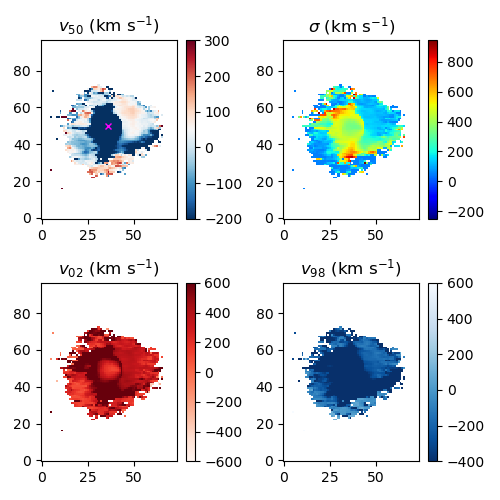

In [14]:
%matplotlib widget

plot_kin(5, fc_1comp, err_fc_1comp, v50_1comp, vsig_1comp, v02_1comp, v98_1comp, spx_x, spx_y, spx=True)
print('SNR =', round(fc_1comp[5][1][spx_y][spx_x]/err_fc_1comp[5][1][spx_y][spx_x],2), 'v50 =',round(v50_1comp[5][1][spx_y][spx_x],2)) 

# First Component 2 components Fit

In [11]:
fc1 = data_flx[5][1][0][8]
err_fc1 = data_flx_err[5][1][0][8]

vsig_c1 = vel_arr[10][1][0][8]
v50_c1 = vel_arr[5][1][0][8]
v98_c1 = vel_arr[28][1][0][8]
v02_c1 = vel_arr[4][1][0][8]

snr_c1 = get_sn(5,fc1,err_fc1)

In [ ]:
%matplotlib widget

figure(figsize=(4,4))
ax = subplot(111)
ax.hist(get_v50(5, fc1, err_fc1, v50_c1),10)
ax.set_xlim(-100,100)
#savefig('iter2_c1_v50_hist.pdf')

In [33]:
spaxel_test = get_values(5,fc1, err_fc1, v50_c1, vsig_c1, v02_c1, v98_c1, spx_x, spx_y)

v50 -104.55 vsig 191.69 v02 278.83 v98 -487.93
o2 flux 1.26 o2_err 0.22 SNR 5.86


SNR = 5.86 v50 = -104.55


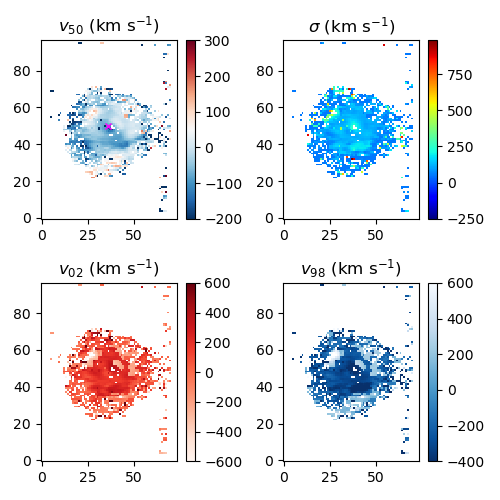

In [34]:
%matplotlib widget

plot_kin(5, fc1, err_fc1, v50_c1, vsig_c1, v02_c1, v98_c1, spx_x, spx_y, spx=True)
print('SNR =', round(fc1[5][1][spx_y][spx_x]/err_fc1[5][1][spx_y][spx_x],2), 'v50 =',round(v50_c1[5][1][spx_y][spx_x],2)) 
savefig('new_2comp_kinematics_firstcomp.pdf')

# Second Component 2 components Fit

In [12]:
fc2 = data_flx[1][1][0][8]
err_fc2 = data_flx_err[1][1][0][8]

vsig_c2 = vel_arr[12][1][0][8]
v50_c2 = vel_arr[18][1][0][8]
v98_c2 = vel_arr[8][1][0][8]
v02_c2 = vel_arr[21][1][0][8]

snr_c2 = get_sn(5,fc2,err_fc2)

In [36]:
spaxel_test = get_values(5,fc2, err_fc2, v50_c2, vsig_c2, v02_c2, v98_c2, spx_x, spx_y)

v50 -618.43 vsig 327.2 v02 35.98 v98 -1272.84
o2 flux 1.04 o2_err 0.14 SNR 7.65


SNR = 7.65 v50 = -618.43


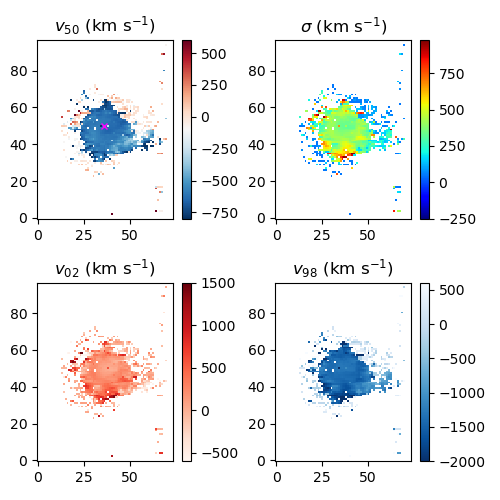

In [37]:
%matplotlib widget
plot_kin_c2(5, fc2, err_fc2, v50_c2, vsig_c2, v02_c2, v98_c2, spx_x, spx_y, spx=True)
print('SNR =', round(fc2[5][1][spx_y][spx_x]/err_fc2[5][1][spx_y][spx_x],2), 'v50 =',round(v50_c2[5][1][spx_y][spx_x],2)) 
savefig('new_2comp_kinematics_secondcomp.pdf')

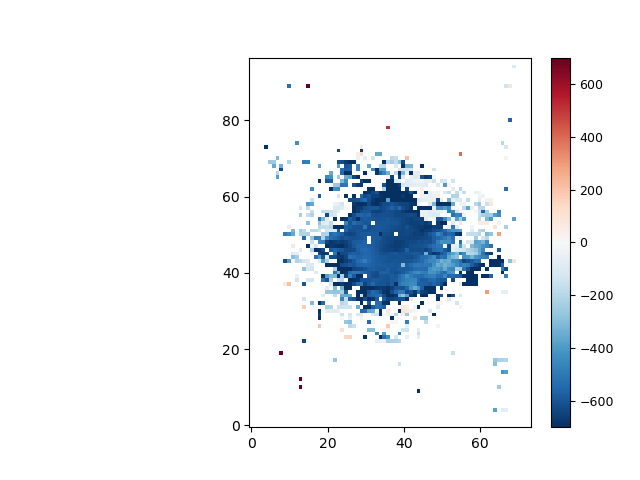

In [20]:
# using new fits file, without sn cut

%matplotlib widget
with fits.open('F05189_o2_2comp_flipped-1comp.fits') as hdul:
    fc2 = hdul['fc2'].data
    err_fc2 = hdul['err_fc2'].data
    v50_c2 = hdul['v50_c2'].data
    # snr_c2 = hdul['snr_c2'].data
    vsig_c2 = hdul['vsig_c2'].data
    v02_c2 = hdul['v02_c2'].data
    v98_c2 = hdul['v98_c2'].data
    spx_x = 36
    spx_y = 50

    subplot(221)
    imshow(v50_c2, origin='lower', cmap='RdBu_r',vmin=-700,vmax=700)
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)


    # print('SNR =', round(fc2[5][1][spx_y][spx_x]/err_fc2[5][1][spx_y][spx_x],2), 'v50 =',round(v50_c2[5][1][spx_y][spx_x],2)) 

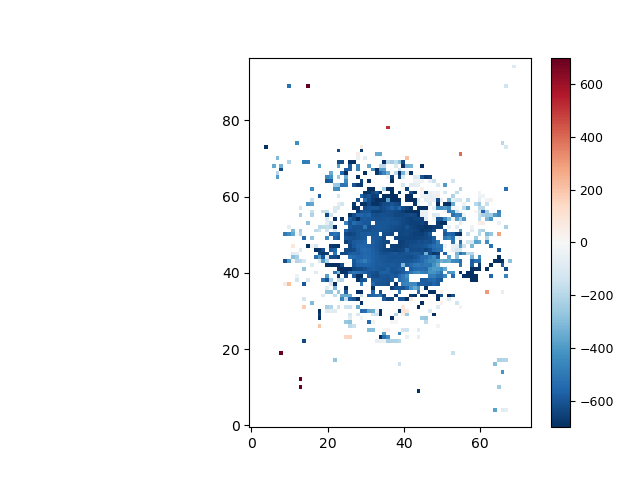

In [21]:
# using new fits file, with sn cut

%matplotlib widget
with fits.open('F05189_o2_2comp_flipped.fits') as hdul:
    fc2 = hdul['fc2'].data
    err_fc2 = hdul['err_fc2'].data
    v50_c2 = hdul['v50_c2'].data
    snr_c2 = hdul['snr_c2'].data
    # vsig_c2 = hdul['vsig_c2'].data
    # v02_c2 = hdul['v02_c2'].data
    # v98_c2 = hdul['v98_c2'].data
    spx_x = 36
    spx_y = 50

    v50_c2_sncut = set_sn(snr_c2, v50_c2)

    imshow(v50_c2_sncut, origin='lower', cmap='RdBu_r',vmin=-700,vmax=700)
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)


    # print('SNR =', round(fc2[5][1][spx_y][spx_x]/err_fc2[5][1][spx_y][spx_x],2), 'v50 =',round(v50_c2[5][1][spx_y][spx_x],2)) 

# Functions to Plot Fits

In [17]:
import matplotlib.ticker as ticker

class Spaxel:
    def __init__(self, infile):
        self.xdr = readsav(infile)
        self.xdr_arr = self.xdr['struct']
        self.wave = self.xdr_arr['wave'][0]
        self.spectot = self.xdr_arr['spec'][0]
        self.specstars = self.xdr_arr['cont_dat'][0]
        self.speclines = self.xdr_arr['emlin_dat'][0]
        self.modstars = self.xdr_arr['cont_fit'][0]
        self.modlines = self.xdr_arr['emlin_fit'][0]
        self.specerr = self.xdr_arr['spec_err'][0]
        self.modtot = self.modstars + self.modlines
        if self.xdr_arr['param'] !=0:
            self.ppoff = self.xdr_arr['param'][0][0]
            self.ncomp = self.xdr_arr['param'][0][1].astype(int)
            self.specres = self.xdr_arr['param'][0][2]
            self.rem_lis = []
        else:
            self.ncomp  = 0
        print(self.ncomp)
        
    def cmplin(self, line, comp):
        if comp == 0:
            return 0
        c = 299792.458
        indices = (self.xdr_arr['parinfo'][0]['line'] == line) & (self.xdr_arr['parinfo'][0]['comp'] == comp)
        if indices[0] != -1:
            gausspar = self.xdr_arr['param'][0][indices]
            gaussparRound = np.around(gausspar, decimals = 7)
            gaussparStr = list(map(str, gaussparRound))
            units = ['', ' Ang', ' km/s']
            gaussparFinal = []
            for i in range(len(gaussparStr)):
                gaussparFinal.append(gaussparStr[i] + units[i])
            #print(gaussparFinal)
            
            if len(gausspar) > 0 and not line in self.rem_lis:
                gausspar[2] = sqrt((gausspar[2]*gausspar[1]/c)**2. + self.specres**2.)
                if gausspar[2] == 0 or gausspar[0] == 0:
                    flux = zeros(len(self.wave)) * nan
                else:
                     flux = gaussian(self.wave,*gausspar)
            else:
                flux = zeros(len(self.wave)) * nan
         #   if line == b'[OII]3726':
         #      print('redshift 3726', gausspar[1]/3727.092-1)
         #   elif line== b'[OII]3729':
         #      print('redshift 3729', gausspar[1]/3729.875-1)
         #   else:
         #      print('not [OII] line', line)
        return flux
    
    def plot_lines(self, ax, lines, xmin, xmax):
        ax.plot(self.wave, self.modstars + self.speclines, 'k', ds='steps-mid', lw=1.)
        col = ['','0','1','2']
        for l in lines:
            for i in range(1,self.ncomp+1):
                style = 'C' + col[i] + '--'
                ax.plot(self.wave,self.modstars + self.cmplin(l, i), style)
        ax.plot(self.wave, self.modstars + self.modlines, 'C3')
        ax.plot(self.wave, self.specerr, 'C6:', ds='steps-mid', lw=1.)
        yi = self.speclines[(self.wave > xmin) & (self.wave < xmax)]
        erri = self.specerr[(self.wave > xmin) & (self.wave < xmax)]
        ymax = max(1.8 * amax(yi), 3. * amax(erri))
        ymin = -0.01 * ymax
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        if xmax - xmin <= 40.:
            tick_spacing = 15
        else:
            tick_spacing = 20
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
        ax.tick_params(axis='x', which='major', labelsize=6)

    def plot_spec(self, ax, xmin, xmax):
        ax.plot(self.wave, self.speclines, 'k', drawstyle='steps-mid', lw=1.5)
        ax.plot(self.wave, self.modlines, 'C3')
        yi = self.speclines[(self.wave > xmin) & (self.wave < xmax)]
        ymax = max(1.2 * amax(yi), 3. * std(yi))
        ymin = 1e-4 * ymax
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        
    def remove_line(self, line):
        iline = zeros(len(self.wave))
        for i in range(1, self.ncomp+1):
            iline += nan_to_num(self.cmplin(line, i))
        self.modlines = self.modlines - iline
        self.modtot = self.modstars + self.modlines
        self.rem_lis.append(line)
        
    def plot_line_vel(self, ax, line, wave, z, vmin, vmax, lw=None):
        c = 299792.458
        wobs = wave * (1. + z)
        vel = c * (self.wave - wobs) / wobs
        ax.plot(vel, self.speclines, 'k', drawstyle='steps-mid', lw=1.)
        col = ['','0','1','2']
        for l in line:
           for i in range(1,self.ncomp+1):
            style = 'C' + col[i] + '--'
            ax.plot(vel, self.cmplin(l, i), style, lw=1.)
        ax.plot(vel, self.modlines, 'C3', lw=lw)
        #ax.plot(vel, self.specerr, 'C6:', ds='steps-mid', lw=lw)
        yi = self.speclines[(vel > vmin) & (vel < vmax)]
        erri = self.specerr[(vel > vmin) & (vel < vmax)]
        #ymax = max(1.8 * amax(yi), 3. * amax(erri))
        #ymin =  ymax
        ax.set_xlim(vmin, vmax)
        #ax.set_ylim(ymin, ymax)
        ax.axvline(0,color='k', ls='--', lw=0.5)
        ax.set_yticks(())
        ax.set_xlabel('(km s$^{-1}$)', fontsize=6, labelpad=-1)
        ax.set_ylabel('flux')

    def plot_lines_pdf(self, lines, xmin, xmax, str_x, str_y, pr=False):
        plt.plot(self.wave, self.modstars + self.speclines, 'k', ds='steps-mid', lw=1.)
        col = ['','0','1','2']
        for l in lines:
            for i in range(1,self.ncomp+1):
                style = 'C' + col[i] + '--'
                plt.plot(self.wave,self.modstars + self.cmplin(l, i), style)
        plt.plot(self.wave, self.modstars + self.modlines, 'C3')
        plt.plot(self.wave, self.specerr, 'C6:', ds='steps-mid', lw=1.)
        yi = self.speclines[(self.wave > xmin) & (self.wave < xmax)]
        erri = self.specerr[(self.wave > xmin) & (self.wave < xmax)]
        ymax = max(2.2 * amax(yi), 3. * amax(erri))
        ymin = -0.01 * ymax
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        if pr == True:
            plt.text(3900, ymax*0.9,  str_x + '_' + str_y, fontsize=9)

    def plot_line_vel_pdf(self, line, wave, z, vmin, vmax, sn1=None, sn2=None, lw=None, sn = False):
        c = 299792.458
        wobs = wave * (1. + z)
        vel = c * (self.wave - wobs) / wobs
        plt.plot(vel, self.speclines, 'k', drawstyle='steps-mid', lw=1.)
        if self.ncomp!=0:
            col = ['','0','1','2']
            for l in line:
                for i in range(1,self.ncomp+1):
                    style = 'C' + col[i] + '--'
                                    xplt.plot(vel, self.cmplin(l, i), style, lw=1.)
            plt.plot(vel, self.modlines, 'C3', lw=lw)

        #ax.plot(vel, self.specerr, 'C6:', ds='steps-mid', lw=lw)
        yi = self.speclines[(vel > vmin) & (vel < vmax)]
        erri = self.specerr[(vel > vmin) & (vel < vmax)]
        ymax = max(1.8 * amax(yi), 3. * amax(erri))
        ymin =  -ymax*0.2
        plt.xlim(vmin, vmax)
        plt.ylim(ymin, ymax)
        plt.axvline(0,color='k', ls='--', lw=0.5)
        if sn == True and self.ncomp!=0:
            plt.text(100, ymax*0.9,  'SNR1='+str(round(sn1,1)), fontsize=7)
            plt.text(100, ymax*0.8,  'SNR2='+str(round(sn2,1)), fontsize=7)

        #ax.set_xlabel('(km s$^{-1}$)', fontsize=6, labelpad=-1)
        #ax.set_ylabel('flux')        
        
def gaussian(x, A, u, sig):
    return A * exp(-(x-u)**2. / 2. / sig**2.)

def plot_spaxel(ax, spax, lxticks=False, ltitle=False, rem=False):
    spax.plot_lines(ax, [b'[OII]3726', b'[OII]3729'], 3850, 3950)
    ax.axvline((z+1)*3726.032, color='k', ls='--', lw=0.5)
    ax.axvline((z+1)*3728.815, color='k', ls='--', lw=0.5)

    if ltitle:
        ax.title.set_text('[OII]3726,9')

 

def plot_spaxel_pdf(spax, str_x, str_y, lxticks=False, ltitle=False, rem=False, pr= False):
    spax.plot_lines_pdf([b'[OII]3726', b'[OII]3729'], 3750, 4050, str_x, str_y, pr)
    plt.axvline((z+1)*3726.032, color='k', ls='--', lw=0.5)
    plt.axvline((z+1)*3728.815, color='k', ls='--', lw=0.5)


In [52]:
# x_y_start = [35,48] lower left
# x_y_end = [38,50] upper right

x_y_start = [35,40]
x_y_end = [40,45]

size_x = x_y_end[0] - x_y_start[0] + 1
size_y = x_y_end[1] - x_y_start[1] + 1

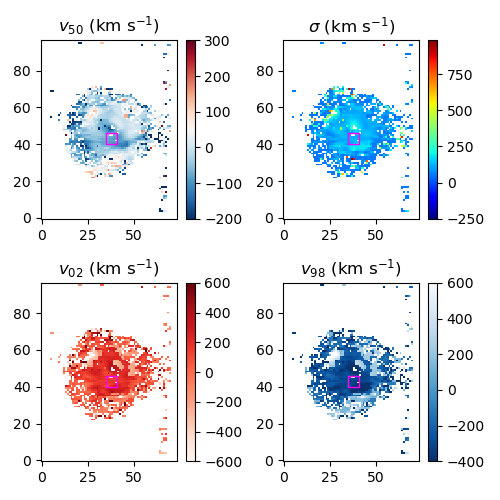

In [53]:
%matplotlib widget
plot_kin(5, fc1, err_fc1, v50_c1, vsig_c1, v02_c1, v98_c1, x_y_start[0], x_y_start[1], size_x, size_y, rec = True)
savefig('iter2_kinematics_first_comp_rec_center.pdf')

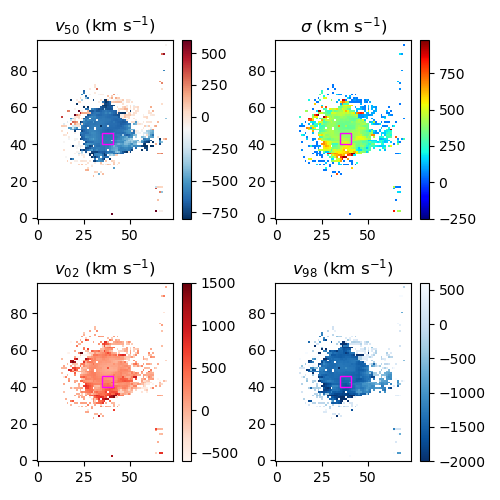

In [54]:
%matplotlib widget
plot_kin_c2(5, fc2, err_fc2, v50_c2, vsig_c2, v02_c2, v98_c2, x_y_start[0], x_y_start[1], size_x, size_y, rec = True)
#savefig('iter2_kinematics_second_comp_rec_center.pdf')

In [56]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec

f = list(zip(x_y_start, x_y_end))

pdf = PdfPages('fits_o2_iter2_rec_center.pdf')

wind = 0
for x in range(0,size_x):
    for y in range(0,size_y):
        
        if wind == 0:
               fig = plt.figure(figsize=(8.5,10.0))
               gs = gridspec.GridSpec(4,4)
               gs.update(left=0.12, right=0.90, top=0.98, bottom=0.08,hspace=0.08)
        ax1 = plt.subplot(gs[wind,0])        
        ne = Spaxel('/raid/KCWI/AGN_outflows/F05189/iter2/F05189_00' + str(x_y_start[0]+x+1) +'_00'+ str(x_y_start[1]+y+1) + '.xdr')
        plot_spaxel_pdf(ne, str(x_y_start[0]+x+1), str(x_y_start[1]+y+1), pr= True)
        ax1.tick_params(labelsize=8)
        if (wind !=3):
            plt.xticks(())
            
        ax2 = plt.subplot(gs[wind,1])        
        ne = Spaxel('/home/acoil/AGN_outflows_ifsfit/F05189/iter3/F05189_00' + str(x_y_start[0]+x+1) +'_00'+ str(x_y_start[1]+y+1) + '.xdr')
        plot_spaxel_pdf(ne, str(x_y_start[0]+x+1), str(x_y_start[1]+y+1))
        plt.yticks(())
        ax2.tick_params(labelsize=8)
        if (wind !=3):
            plt.xticks(())
            
        ax3 = plt.subplot(gs[wind,2])        
        ne = Spaxel('/raid/KCWI/AGN_outflows/F05189/iter2/F05189_00' + str(x_y_start[0]+x+1) +'_00'+ str(x_y_start[1]+y+1) + '.xdr')        
        ne.plot_line_vel_pdf([b'[OII]3729', b'[OII]3726'], 3726.03, z, -2500, 2500, snr_c1[x_y_start[1]+y][x_y_start[0]+x], snr_c2[x_y_start[1]+y][x_y_start[0]+x], sn=True)
        plt.yticks(())
        ax3.tick_params(labelsize=8)
        if (wind !=3):
            plt.xticks(())
            
        ax4 = plt.subplot(gs[wind,3])        
        ne = Spaxel('/home/acoil/AGN_outflows_ifsfit/F05189/iter3/F05189_00' + str(x_y_start[0]+x+1) +'_00'+ str(x_y_start[1]+y+1) + '.xdr')        
        ne.plot_line_vel_pdf([b'[OII]3729', b'[OII]3726'], 3726.03, z, -2500, 2500, snr_1comp[x_y_start[1]+y][x_y_start[0]+x], 0, sn=True)
        ax4.yaxis.set_label_position('right')
        ax4.yaxis.tick_right()
        ax4.tick_params(labelsize=8)
        if (wind !=3):
            plt.xticks(())
        
        
        if wind == 3:
            plt.savefig(pdf, format='pdf',bbox_inches='tight')
            plt.close()
            wind = 0
        else:
            wind = wind + 1

if wind == 1 or wind == 2 or wind == 3:
    plt.savefig(pdf, format='pdf',bbox_inches='tight')
    plt.close()
pdf.close()    
        

/tmp/ipykernel_26014/3353075791.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if self.xdr_arr['param'] !=0:


2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


: 

# Natalie's analysis

## comparing spaxels

2
['0.084613', '3885.3359403 Ang', '191.6902194 km/s']
['0.0432865', '3878.681704 Ang', '327.2045974 km/s']
['0.1015356', '3888.2376887 Ang', '191.6902194 km/s']
['0.0519438', '3881.5784827 Ang', '327.2045974 km/s']


/tmp/ipykernel_13492/4197301923.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if self.xdr_arr['param'] !=0:


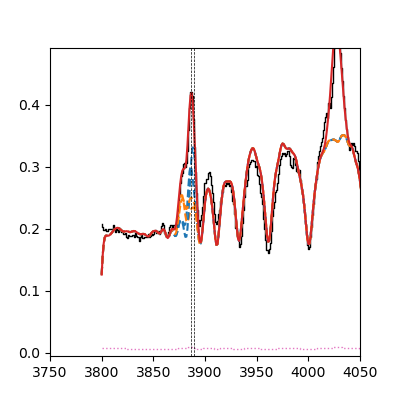

In [28]:
# plotting specific spaxel (36,50)

spx_x_comp = 36
spx_y_comp = 50

%matplotlib widget
figure(figsize=(4,4))
ax = subplot(111)
ne = Spaxel('/raid/KCWI/AGN_outflows/F05189/iter2/F05189_00' + str(spx_x_comp+1) +'_00'+ str(spx_y_comp+1) + '.xdr')   
plot_spaxel_pdf(ne, spx_x_comp, spx_y_comp)
#savefig('test.pdf')

# to print, uncomment line in cmplin
# amp, center wavelength (lambda(OII)*(1+zsys)), sigma
# check lambda(OII) in calculate scales

In [29]:
# getting v50 from the main .xdr

spaxel_test = get_values(5,fc2, err_fc1, v50_c1, vsig_c1, v02_c1, v98_c1, 36, 50)
spaxel_test = get_values(5,fc2, err_fc2, v50_c2, vsig_c2, v02_c2, v98_c2, 36, 50)


v50 -104.55 vsig 191.69 v02 278.83 v98 -487.93
o2 flux 1.04 o2_err 0.22 SNR 4.84
v50 -618.43 vsig 327.2 v02 35.98 v98 -1272.84
o2 flux 1.04 o2_err 0.14 SNR 7.65


Investigating single spaxel fit

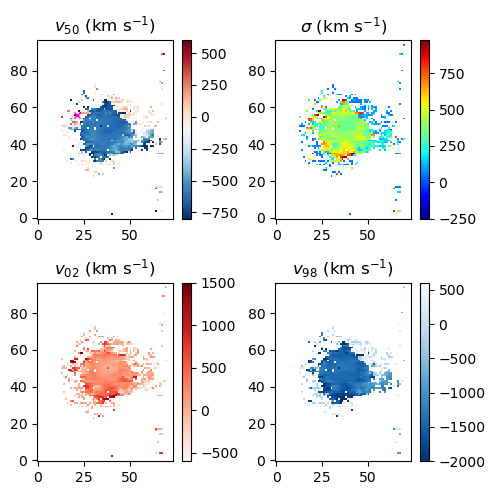

In [52]:
%matplotlib widget

spx_x_test = 21
spx_y_test = 56
plot_kin_c2(5, fc2, err_fc2, v50_c2, vsig_c2, v02_c2, v98_c2, spx_x_test, spx_y_test, spx=True)
#print('SNR =', round(fc2[5][1][spx_y][spx_x]/err_fc2[5][1][spx_y][spx_x],2), 'v50 =',round(v50_c2[5][1][spx_y][spx_x],2)) 


2


/tmp/ipykernel_32682/3353075791.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if self.xdr_arr['param'] !=0:


([], [])

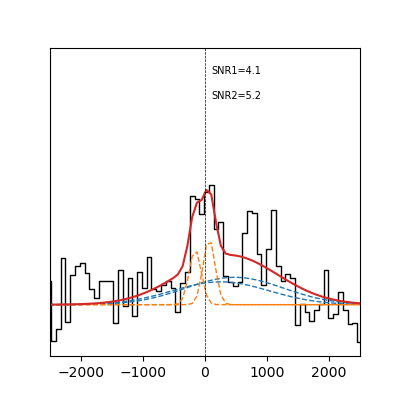

In [54]:
%matplotlib widget

figure(figsize=(4,4))
ax = subplot(111)
ne = Spaxel('/raid/KCWI/AGN_outflows/F05189/iter2/F05189_00' + str(spx_x_test+1) +'_00'+ str(spx_y_test+1) + '.xdr')   
ne.plot_line_vel_pdf([b'[OII]3729', b'[OII]3726'], 3726.03, z, -2500, 2500, snr_c1[spx_y_test][spx_x_test], snr_c2[spx_y_test][spx_x_test], sn=True)
plt.yticks(())
#ax3.tick_params(labelsize=8)
#savefig('test.pdf')


## sn map for 2comp

In [40]:
def get_sn(idx, arr, arr2):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])

    # f = set_bad(f)
    # f_err = set_bad(f_err)
    
#     for row in range(f_err.shape[0]):
#         for column in range(f_err.shape[1]):
#             if(f_err[row][column] < err_thresh):
#                 f_err[row][column] = err_thresh
    
    sn = f/f_err  
    return sn

def plot_sn_c2(idx, f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, spx=False, rec= False):
    figure(figsize=(5,5))
    
    v50_line = get_v50(idx, f_temp, err_f_temp, v50_temp)
    vsig_line = get_vsig(idx, f_temp, err_f_temp, vsig_temp)
    sn_line = get_sn(idx, f_temp, err_f_temp)
    
          
    subplot(221)
    imshow(v50_line, origin='lower', cmap='RdBu_r', vmin=-800, vmax=600, interpolation='none') #, vmin=-800, vmax=600,
    if spx == True:
        plt.plot(spx_x, spx_y, marker="x", markersize=5, markeredgecolor="magenta", markerfacecolor="magenta")
    ax = gca()
    colorbar()
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect)    
    ax.title.set_text('$v_{50}\ \mathrm{(km\ s^{-1})}$')

    subplot(222)
    imshow(vsig_line, origin='lower', cmap='jet', vmin=-250, interpolation='none')#, vmin=200, vmax=350) 
    ax = gca()
    colorbar()
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect)       
    ax.title.set_text('$\sigma\ \mathrm{(km\ s^{-1})}$')
    
    subplot(223)
    imshow(sn_line, origin='lower', cmap='Reds', vmin=0, vmax=20, interpolation='none') 
    ax = gca()
    colorbar()
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect)       
    ax.title.set_text('sn')

    subplot(224)
    imshow(sn_line, origin='lower', cmap='Reds', vmin=0, vmax=8, interpolation='none') 
    ax = gca()
    colorbar()
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect)       
    ax.title.set_text('sn')

    tight_layout()

/tmp/ipykernel_26014/1030791531.py:31: RuntimeWarning: divide by zero encountered in divide
  sn = f/f_err
/tmp/ipykernel_26014/1030791531.py:31: RuntimeWarning: invalid value encountered in divide
  sn = f/f_err


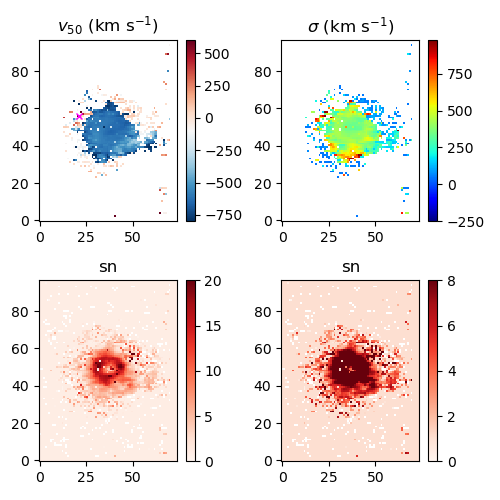

In [41]:
spx_x_test = 21
spx_y_test = 56
plot_sn_c2(5, fc2, err_fc2, v50_c2, vsig_c2, v02_c2, v98_c2, spx_x_test, spx_y_test, spx=True)


In [15]:
# create FITS file to store snr
n = np.zeros((len(snr_c1), len(snr_c1[0])))
primary_hdu = fits.PrimaryHDU(n)

OII3726_3729_snr_hdu = fits.BinTableHDU.from_columns([
                fits.Column(name='snr1comp', format='74D', array=snr_1comp),
                fits.Column(name='snrc1', format='74D', array=snr_c1),
                fits.Column(name='snrc2', format='74D', array=snr_c2),
                ])
hdul = fits.HDUList([primary_hdu, OII3726_3729_snr_hdu])
hdul.writeto('F05189_noflip_snr.fits')
